In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import string
from collections import Counter
from imblearn.pipeline import Pipeline  
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import  WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer 
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, auc
from wordcloud import WordCloud
import shap

In [2]:
# Listing Dataset
df_listings = pd.read_csv(r"listings.csv")

#Reviews Dataset
df_reviews = pd.read_csv(r"reviews.csv")

In [3]:
#Exploracion del Dataset Listing

print(df_listings.head())
print(df_listings.duplicated().sum())
#Parece no haber valores duplicados

      id                         listing_url       scrape_id last_scraped  \
0  35797  https://www.airbnb.com/rooms/35797  20250319150644   2025-03-21   
1  44616  https://www.airbnb.com/rooms/44616  20250319150644   2025-03-20   
2  56074  https://www.airbnb.com/rooms/56074  20250319150644   2025-03-20   
3  67703  https://www.airbnb.com/rooms/67703  20250319150644   2025-03-20   
4  70644  https://www.airbnb.com/rooms/70644  20250319150644   2025-03-22   

            source                                              name  \
0      city scrape                                       Villa Dante   
1  previous scrape                                      Condesa Haus   
2      city scrape              Great space in historical San Rafael   
3  previous scrape                 2 bedroom apt. deco bldg, Condesa   
4      city scrape  Beautiful light Studio Coyoacan- full equipped !   

                                         description  \
0  Dentro de Villa un estudio de arte con futon,

In [4]:
print(df_listings.shape)
#En total tengo 26067 filas y 79 columnas
print(df_listings.info())
print(df_listings.isnull().sum())


(26067, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26067 entries, 0 to 26066
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            26067 non-null  int64  
 1   listing_url                                   26067 non-null  object 
 2   scrape_id                                     26067 non-null  int64  
 3   last_scraped                                  26067 non-null  object 
 4   source                                        26067 non-null  object 
 5   name                                          26067 non-null  object 
 6   description                                   25300 non-null  object 
 7   neighborhood_overview                         14391 non-null  object 
 8   picture_url                                   26067 non-null  object 
 9   host_id                                       260

In [5]:
# LIMPIEZA E IMPUTACIÓN DE DATOS

# 1. Eliminamos las columnas que tengan solo valores nulos o que sean innecesarias en este estudio.
columnas_drop = [
    'neighbourhood_group_cleansed', 'calendar_updated', 'license', 'host_about', 'reviews_per_month', 
    'host_location', 'host_neighbourhood', 'host_thumbnail_url', 'host_verifications', 'host_picture_url', 'host_since',
    'last_scraped', 'first_review', 'last_review', 'calendar_last_scraped', 'neighbourhood', 'bathrooms', 'host_listings_count', 'has_availability',
    'host_total_listings_count', 'host_name', 'listing_url', 'scrape_id', 'host_url', 'picture_url'
]

df_listings.drop(columns=columnas_drop, inplace=True, errors='ignore')

# 2. Eliminamos las filas que no tengan precio. No las imputamos porque es algo que define el host, consideramos que no era conveniente.
# Luego, convertimos la columna price a valores numéricos, y eliminamos el signo de $

df_listings = df_listings.dropna(subset=['price'])

if df_listings['price'].dtype == 'object':  
    df_listings['price'] = df_listings['price'].replace('[\$,]', '', regex=True).astype(float)

# 3. Eliminamos las filas vacías para los baños nos quedamos solo con el numero de baños (eliminando el texto que lo acompaña)
df_listings = df_listings.dropna(subset=['bathrooms_text'])
df_listings['bathrooms_text'] = df_listings['bathrooms_text'].apply(
    lambda x: float(re.match(r'^\d+(\.\d+)?', str(x)).group()) if re.match(r'^\d+(\.\d+)?', str(x)) else None
)
df_listings = df_listings.dropna(subset=['bathrooms_text']) 

# 4. Le asignamos el valor de "Descripción no disponible" a las filas vacías de la columna: 'neighborhood_overview'
df_listings['neighborhood_overview'] = df_listings['neighborhood_overview'].fillna('Descripción no disponible')

# 5. Imputamos la columna de review_scores con la mediana (####POSIBLE ELIMINACION DE VALORES NULOS)
review_score_cols = [col for col in df_listings.columns if col.startswith('review_scores')]
for col in review_score_cols:
    if df_listings[col].dtype in [np.float64, np.int64, float, int]:
        df_listings[col] = df_listings[col].fillna(df_listings[col].median())

# 6. Imputamos las columnas de tipo Cierto/Falso con el valor de "Falso"
bool_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    df_listings[col] = df_listings[col].map({'t': True, 'f': False})
    df_listings[col] = df_listings[col].fillna(False)

# 7. Imputamos las columnas relacionadas con las infraestructura del Airbnb con la mediana, 
#porque puede ser algo importante al momento de dejar un review. Por eso no lo eliminamos
infra_cols = ['bathrooms_text', 'bedrooms', 'beds']
for col in infra_cols:
    if col in df_listings.columns:
        df_listings[col] = df_listings[col].fillna(df_listings[col].median())

# 8. Limpiar y convertir tasas porcentuales a decimales e imputamos con la media
if 'host_response_rate' in df_listings.columns:
    if df_listings['host_response_rate'].dtype == 'object':
        df_listings['host_response_rate'] = (
            df_listings['host_response_rate'].str.rstrip('%').astype(float) / 100
        )
    df_listings['host_response_rate'] = df_listings['host_response_rate'].fillna(
        df_listings['host_response_rate'].mean()
    )

if 'host_acceptance_rate' in df_listings.columns:
    if df_listings['host_acceptance_rate'].dtype == 'object':
        df_listings['host_acceptance_rate'] = (
            df_listings['host_acceptance_rate'].str.rstrip('%').astype(float) / 100
        )
    df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].fillna(
        df_listings['host_acceptance_rate'].mean()
    )

# 9. Imputamos la columna 'host_response_time' con la moda
if 'host_response_time' in df_listings.columns:
    df_listings['host_response_time'] = df_listings['host_response_time'].fillna(
        df_listings['host_response_time'].mode()[0]
    )

# 10. Imputamos las columnas de texto vacías con 'No disponible' para las descripciones
text_cols = ['description']
for col in text_cols:
    if col in df_listings.columns:
        # Reemplaza espacios vacíos o strings vacíos por NaN
        df_listings[col] = df_listings[col].replace(r'^\s*$', np.nan, regex=True)
        # Imputa NaN con 'No disponible'
        df_listings[col] = df_listings[col].fillna('No disponible')


<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Dell\AppData\Local\Temp\ipykernel_20268\1209712818.py:19: SyntaxWarning: invalid escape sequence '\$'
  df_listings['price'] = df_listings['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20268\1209712818.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_listings[col] = df_listings[col].fillna(False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_20268\1209712818.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_d

In [6]:
print(df_listings.shape)
print(df_listings.info())
print(df_listings.isnull().sum())
df_listings.to_csv('Dataset Listings Limpio.csv', index=False)

(21971, 54)
<class 'pandas.core.frame.DataFrame'>
Index: 21971 entries, 0 to 26066
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21971 non-null  int64  
 1   source                                        21971 non-null  object 
 2   name                                          21971 non-null  object 
 3   description                                   21971 non-null  object 
 4   neighborhood_overview                         21971 non-null  object 
 5   host_id                                       21971 non-null  int64  
 6   host_response_time                            21971 non-null  object 
 7   host_response_rate                            21971 non-null  float64
 8   host_acceptance_rate                          21971 non-null  float64
 9   host_is_superhost                             21971 no

In [7]:
#Exploracion del Dataset Reviews

print(df_reviews.head())
print(df_reviews.duplicated().sum())
#Parece no haber valores duplicados

   listing_id       id        date  reviewer_id     reviewer_name  \
0       44616   706908  2011-11-09       634733           Lindsay   
1       44616  2006160  2012-08-16      3087087            Samuel   
2       44616  3174954  2012-12-28      3234920              Anna   
3       44616  3271579  2013-01-04      2199822  Shelley And Pall   
4       44616  3841065  2013-03-19      2423825          Leonardo   

                                            comments  
0  Forget staying in a hotel. Stay at condesa hau...  
1  Fantastic location, great place, friendly host...  
2  I would highly recommend Condesa Haus for anyo...  
3             Great stay. Thanks. Highly recommend.   
4  This was not a very good experience I am afrai...  
0


In [8]:
print(df_reviews.shape)
#En total tengo 1,315,986 filas y 6 columnas
print(df_reviews.info())
print(df_reviews.isnull().sum())

#Tengo valores nulos en la columna de comentarios, una columna importante para el estudio.

(1315986, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315986 entries, 0 to 1315985
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1315986 non-null  int64 
 1   id             1315986 non-null  int64 
 2   date           1315986 non-null  object
 3   reviewer_id    1315986 non-null  int64 
 4   reviewer_name  1315976 non-null  object
 5   comments       1315819 non-null  object
dtypes: int64(3), object(3)
memory usage: 60.2+ MB
None
listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name     10
comments         167
dtype: int64


In [9]:
#La columna reviewer name tambien tiene valores nulos, no es muy importante y nos puede ayudar trabajar con reseñas anonimas.
#Se eliminan entonces las filas con valores vacios de la columna reviewer name

df_reviews.drop(columns='reviewer_name', inplace=True, errors='ignore')

#Imputamos la columna de comentarios, reemplazando los valores vacíos con un 'Sin comentarios' solo para descripciones
df_reviews['comments'] = df_reviews['comments'].replace(r'^\s*$', np.nan, regex=True)
df_reviews['comments'] = df_reviews['comments'].fillna('Sin comentarios')

In [10]:
print(df_reviews.shape)
print(df_reviews.info())
print(df_reviews.isnull().sum())
df_reviews.to_csv('Dataset Reviews Limpio.csv', index=False)

(1315986, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315986 entries, 0 to 1315985
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   listing_id   1315986 non-null  int64 
 1   id           1315986 non-null  int64 
 2   date         1315986 non-null  object
 3   reviewer_id  1315986 non-null  int64 
 4   comments     1315986 non-null  object
dtypes: int64(3), object(2)
memory usage: 50.2+ MB
None
listing_id     0
id             0
date           0
reviewer_id    0
comments       0
dtype: int64


In [11]:
#UNIMOS AMBOS DATASETS USANDO COMO CLAVE COMÚN LAS COLUMNAS DE ID (DF_LISTING) Y LISTING_ID (DF_REVIEWS)

df_merged = pd.merge(df_reviews, df_listings, left_on='listing_id', right_on='id', how='inner')

print(df_merged.info())
df_merged.to_csv('Dataset Combinado.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208139 entries, 0 to 1208138
Data columns (total 59 columns):
 #   Column                                        Non-Null Count    Dtype  
---  ------                                        --------------    -----  
 0   listing_id                                    1208139 non-null  int64  
 1   id_x                                          1208139 non-null  int64  
 2   date                                          1208139 non-null  object 
 3   reviewer_id                                   1208139 non-null  int64  
 4   comments                                      1208139 non-null  object 
 5   id_y                                          1208139 non-null  int64  
 6   source                                        1208139 non-null  object 
 7   name                                          1208139 non-null  object 
 8   description                                   1208139 non-null  object 
 9   neighborhood_overview              

In [12]:
#FORMULACIÓN DEL PROBLEMA

#Definir una variable objetivo (target) basada en las calificaciones,
df_merged['target'] = df_merged['review_scores_rating'].apply(lambda r: 1 if r >= 4.5 else 0)

# Ver distribución de clases
print("Distribución de clases:")
print(df_merged['target'].value_counts())

# Ver primeras filas
df_merged.head()

Distribución de clases:
target
1    1172950
0      35189
Name: count, dtype: int64


,listing_id,id_x,date,reviewer_id,comments,id_y,source,name,description,neighborhood_overview,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,target
0,544105,168527091,2017-07-09,138011288,"Elizabeth, and her family, were outstanding ho...",544105,city scrape,Polanco great location! Priv Room in Shared Apart,Private room with full private bathroom in SHA...,Literally you walk to four malls around.<br />...,...,4.94,4.94,4.99,4.79,False,1,0,1,0,1
1,544105,194032083,2017-09-15,125722250,Excelente anfitriona y excelentes instalaciones.,544105,city scrape,Polanco great location! Priv Room in Shared Apart,Private room with full private bathroom in SHA...,Literally you walk to four malls around.<br />...,...,4.94,4.94,4.99,4.79,False,1,0,1,0,1
2,544105,296781798,2018-07-26,137145951,"Recomiendo ampliamente a Elizabeth, ella y su ...",544105,city scrape,Polanco great location! Priv Room in Shared Apart,Private room with full private bathroom in SHA...,Literally you walk to four malls around.<br />...,...,4.94,4.94,4.99,4.79,False,1,0,1,0,1
3,544105,322661425,2018-09-13,27813417,Muy buen lugar para quedarse y en un edificio ...,544105,city scrape,Polanco great location! Priv Room in Shared Apart,Private room with full private bathroom in SHA...,Literally you walk to four malls around.<br />...,...,4.94,4.94,4.99,4.79,False,1,0,1,0,1
4,544105,337829115,2018-10-17,84986866,Elizabeth’s place is very nice and clean. They...,544105,city scrape,Polanco great location! Priv Room in Shared Apart,Private room with full private bathroom in SHA...,Literally you walk to four malls around.<br />...,...,4.94,4.94,4.99,4.79,False,1,0,1,0,1


In [13]:
#LIMPIEZA DE TEXTO

nombres_columnas = df_merged.columns.tolist()
# Imprimir los nombres de las columnas
print(nombres_columnas)

['listing_id', 'id_x', 'date', 'reviewer_id', 'comments', 'id_y', 'source', 'name', 'description', 'neighborhood_overview', 'host_id', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communica

In [14]:
#VAMOS A VER CUALES SON LAS COLUMNAS TIPO TEXTO
columnas_texto = df_merged.select_dtypes(include=['object']).columns.tolist()
print(columnas_texto)

['date', 'comments', 'source', 'name', 'description', 'neighborhood_overview', 'host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities']


In [15]:
# Luego de una segunda evaluación, filtramos las columnas que consideramos más relevantes, esto con el fin de hacer el dataset mucho más pequeño a la hora de trabajarlo
columnas_relevantes = ['listing_id', 'host_id', 'id_x', 'id_y', 'name', 'description', 'comments', 'neighborhood_overview', 'host_is_superhost', 
                       'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 'target']
# Filtramos el DataFrame para conservar solo las columnas relevantes
df_fc = df_merged[columnas_relevantes]


print(df_fc.head())


# Guardamos el nuevo dataset
df_fc.to_csv('Datos_Completos_finales.csv', index=False)

   listing_id  host_id       id_x    id_y  \
0      544105  2674950  168527091  544105   
1      544105  2674950  194032083  544105   
2      544105  2674950  296781798  544105   
3      544105  2674950  322661425  544105   
4      544105  2674950  337829115  544105   

                                                name  \
0  Polanco great location! Priv Room in Shared Apart   
1  Polanco great location! Priv Room in Shared Apart   
2  Polanco great location! Priv Room in Shared Apart   
3  Polanco great location! Priv Room in Shared Apart   
4  Polanco great location! Priv Room in Shared Apart   

                                         description  \
0  Private room with full private bathroom in SHA...   
1  Private room with full private bathroom in SHA...   
2  Private room with full private bathroom in SHA...   
3  Private room with full private bathroom in SHA...   
4  Private room with full private bathroom in SHA...   

                                            comments  \

****Antes de Iniciar la parte de Preprocesamiento de texto, debemos realizar el filtrado del mismo, se le colocó un contador con una muestra para ver el idioma que predomina y luego realizamos el filtrado del idioma que predomina el cual es el ingles, esto se muestra en el otro código adjunto "Filtro_EN" no se realizó el llamado del mismo a este código principal debido a que demora aprox. 2 horas y 30 min en procesar.

In [16]:
#Dataframe Filtrado por el idioma ingles
df_EN = pd.read_csv(r"Archivo_Filtrado_EN.csv")

In [17]:
#PREPROCESAMIENTO DE TEXTO
## Descargamos recursos necesarios
nltk.download('stopwords') #Para las Stopword o palabras vacias
nltk.download('punkt') #Para la tokenizacion
nltk.download('wordnet') #Se usa para la lematizacion, Sin este recurso, el WordNetLemmatizer no podrá funcionar correctamente.

#Lista de palabras vacias en ingles
stop_words = set(stopwords.words("english"))
#Iniciar el lematizador
lemmatizer = WordNetLemmatizer()
 
def preprod_txt(text):
    text = str(text)
    text = text.lower() #minusculas
    text = re.sub(r'[^a-zA-Z]', ' ', text) #puntuación
    text = re.sub(r'<.*?>', ' ', text)  # HTML
    token = word_tokenize(text) #tokenizador
    token = [word for word in token if word not in stop_words] #Eliminacion de stopworks 
    token = [lemmatizer.lemmatize(word) for word in token]  # Lematización
    return ' '.join(token)
 
df_EN['clean_text'] = df_EN['comentario_limpio'].apply(preprod_txt)
df_EN[['comments','comentario_limpio', 'clean_text']].head(15) #Comentario_limpio es despues del filtrado, antes del preprocesamiento de text, clean_text ya es despues del preprocesamiento de datos.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,comments,comentario_limpio,clean_text
0,"Elizabeth, and her family, were outstanding ho...","Elizabeth, and her family, were outstanding ho...",elizabeth family outstanding host moment arriv...
1,Elizabeth’s place is very nice and clean. They...,Elizabeth’s place is very nice and clean. They...,elizabeth place nice clean helpful responsive ...
2,"Very clean, very convenient, very good as desc...","Very clean, very convenient, very good as desc...",clean convenient good described worth host great
3,"Elizabeth and Oscar are very hospitable, the s...","Elizabeth and Oscar are very hospitable, the s...",elizabeth oscar hospitable stay comfortable wi...
4,Great location great people,Great location great people,great location great people
5,"Considering the excellent location, the pricin...","Considering the excellent location, the pricin...",considering excellent location pricing fair ho...
6,"The location is so good, with city market and ...","The location is so good, with city market and ...",location good city market museo soumaya museo ...
7,"Perfect location, very kind and helpful hosts,...","Perfect location, very kind and helpful hosts,...",perfect location kind helpful host sweet dog h...
8,If you are looking for a family around who is ...,If you are looking for a family around who is ...,looking family around always positive want kno...
9,"You can’t beat the location, easy access & saf...","You can’t beat the location, easy access & saf...",beat location easy access safe walk around hou...


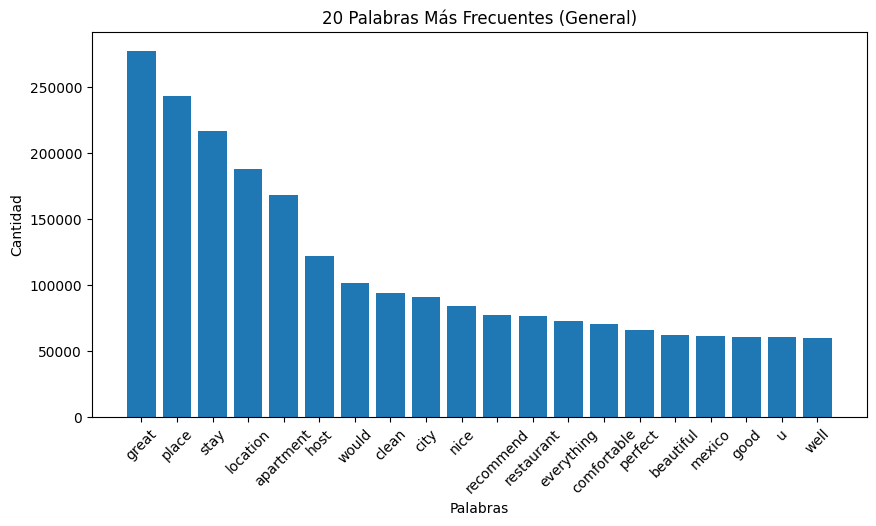

In [18]:
#Antes de avanzar con la Vectorizacion haremos una grafica de barras para ver las palabras mas comunes

#Funcion para contar las palabras en general
def palabras_frecuentes_generales(df_EN, filename='palabras_mas_frecuentes.png'):
    words = ' '.join(df_EN['clean_text']).split()
    most_common = Counter(words).most_common(20)
    labels, counts = zip(*most_common)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.title('20 Palabras Más Frecuentes (General)')
    plt.xlabel('Palabras')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.savefig(filename)
    
palabras_frecuentes_generales(df_EN, 'palabras_mas_frecuentes.png')


In [19]:
#Vectorizacion 
#Utilizaremos TfidfVectorizer ya que el mismo es mas recomendado a la hora de trabajar opiniones

vectorizer = TfidfVectorizer()
X_tf = vectorizer.fit_transform(df_EN['clean_text'])
print("Matriz TF-IDF shape:", X_tf.shape)

Matriz TF-IDF shape: (405048, 47283)


In [20]:
#Ahora probaremos con diferentes parametros

# ngram (1,1)--Unigrama
X_tf_1 = TfidfVectorizer(ngram_range=(1,1))
X_1_1 = X_tf_1.fit_transform(df_EN['clean_text'])
print ('Unigrama')
print(X_tf_1.get_feature_names_out())

#ngram (1,2)--Bigrama
X_tf_2 = TfidfVectorizer(ngram_range=(1,2))
X_1_2 = X_tf_2.fit_transform(df_EN['clean_text'])
print ('\nBigrama')
print(X_tf_2.get_feature_names_out())

# MAX y MIN
#max_df=0.8: ignora las palabras que aparecen en más del 80% de los documentos (son poco informativas).
#min_df=2: solo conserva las palabras que aparecen al menos en 2 documentos (eliminas palabras muy raras).
X_tf_mm = TfidfVectorizer(max_df=0.8, min_df=2)
X_df = X_tf_mm.fit_transform(df_EN['clean_text'])
print ('\nMAX y MIN')
print(X_tf_mm.get_feature_names_out())

#Comparacion de Vocabulario
print ('\nComparacion de Vocabulario')
print("Vocabulario unigramas (1,1):", X_tf_1.get_feature_names_out())
print("Vocabulario bigramas (1,2):", X_tf_2.get_feature_names_out())
print("Vocabulario con min_df y max_df:", X_tf_mm.get_feature_names_out())

#Palabras Generadas
print ('\nPalabras Generadas')
print("Unigramas (1,1):", len(X_tf_1.get_feature_names_out()))
print("Bigramas (1,2):", len(X_tf_2.get_feature_names_out()))
print("Vocabulario con min_df y max_df:", len(X_tf_mm.get_feature_names_out()))

Unigrama
['aa' 'aaa' 'aaaa' ... 'zzzz' 'zzzzz' 'zzzzzz']

Bigrama
['aa' 'aa awesome' 'aa big' ... 'zzzzz traveling' 'zzzzzz' 'zzzzzz thank']

MAX y MIN
['aa' 'aaa' 'aaaa' ... 'zurich' 'zyntya' 'zzz']

Comparacion de Vocabulario
Vocabulario unigramas (1,1): ['aa' 'aaa' 'aaaa' ... 'zzzz' 'zzzzz' 'zzzzzz']
Vocabulario bigramas (1,2): ['aa' 'aa awesome' 'aa big' ... 'zzzzz traveling' 'zzzzzz' 'zzzzzz thank']
Vocabulario con min_df y max_df: ['aa' 'aaa' 'aaaa' ... 'zurich' 'zyntya' 'zzz']

Palabras Generadas
Unigramas (1,1): 47283
Bigramas (1,2): 1658591
Vocabulario con min_df y max_df: 25142


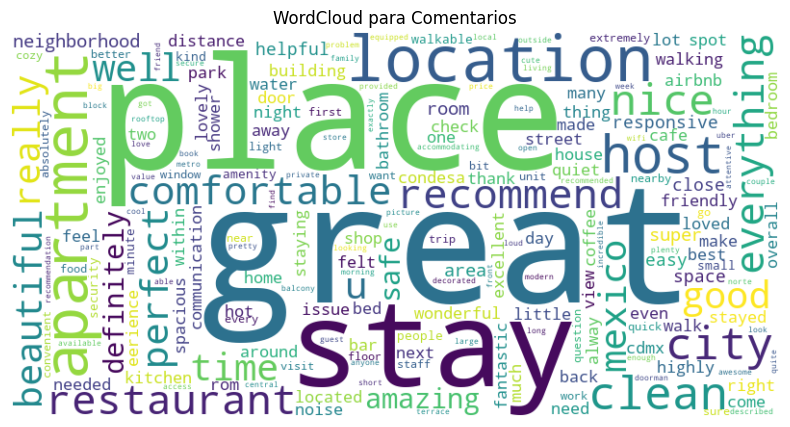

In [21]:
#Visualizaciones
#Generar una WordCloud 
Text_comment = ' '.join(df_EN['clean_text'])
word_freq = Counter(Text_comment.split())
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(Text_comment)

# Grafica de WordCloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud para Comentarios')
plt.savefig('wordcloud_para_comentarios.png') 
plt.show()


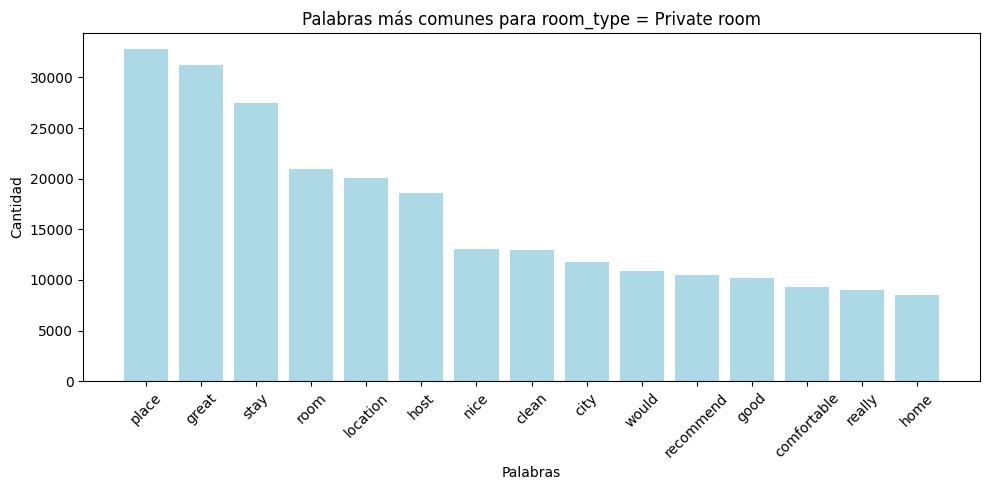

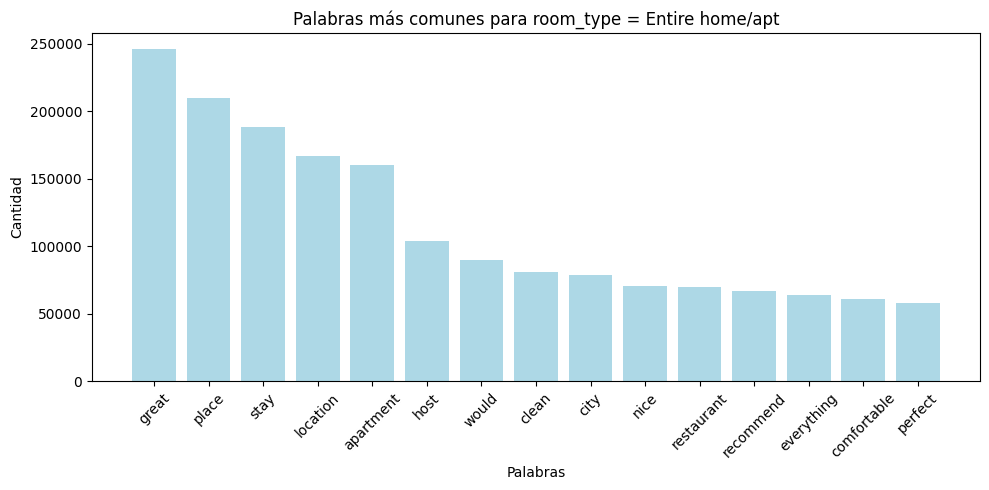

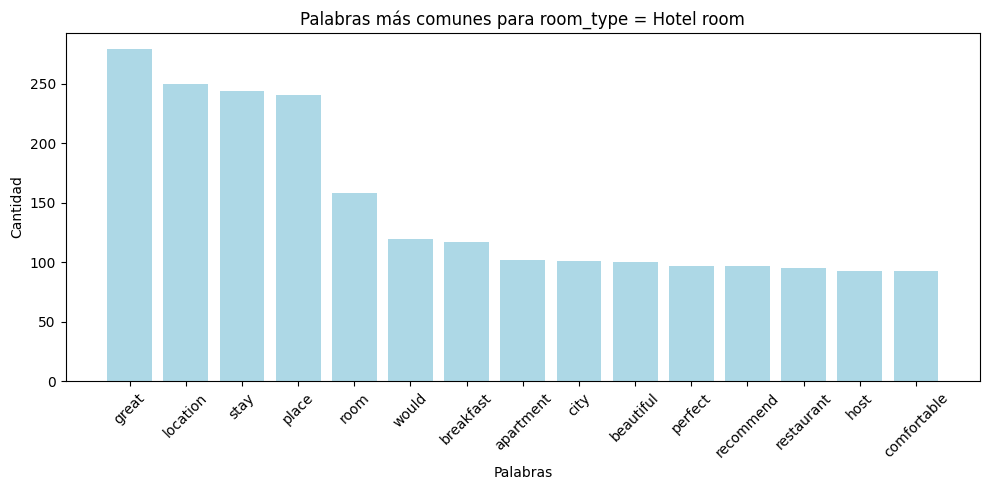

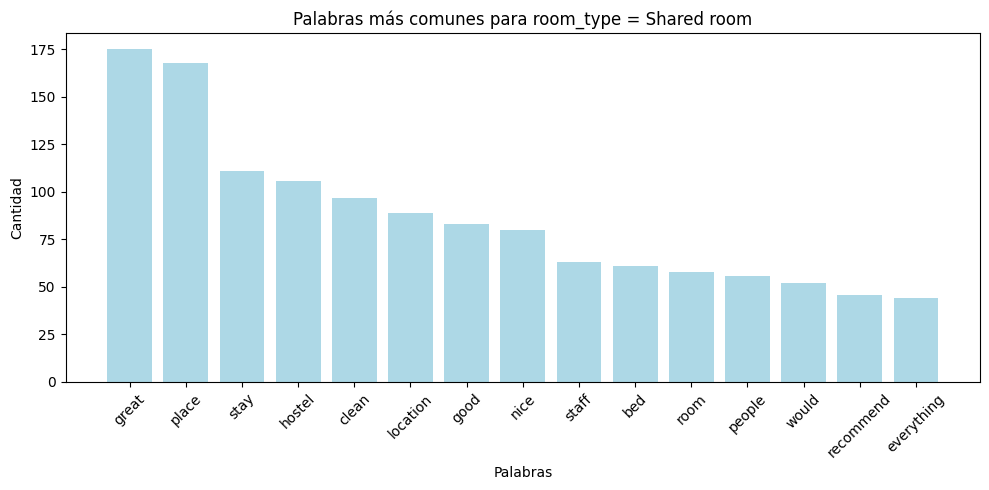

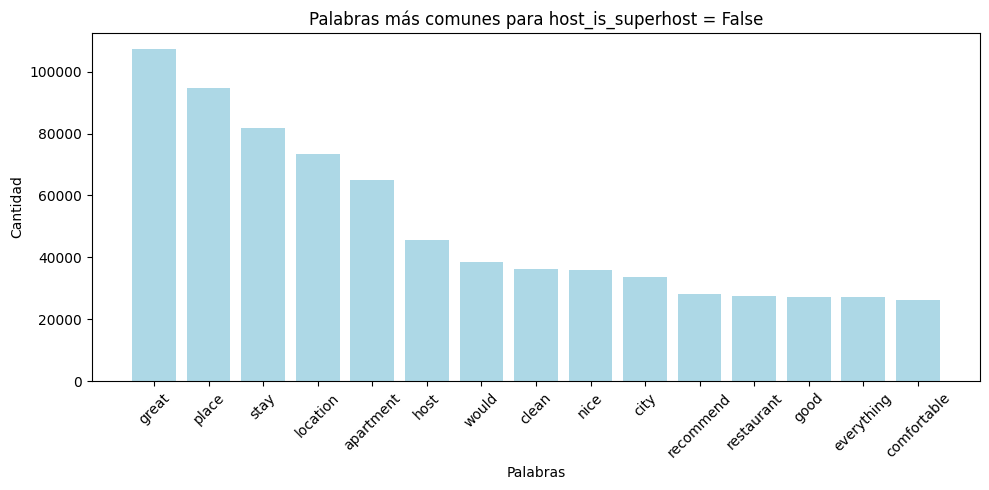

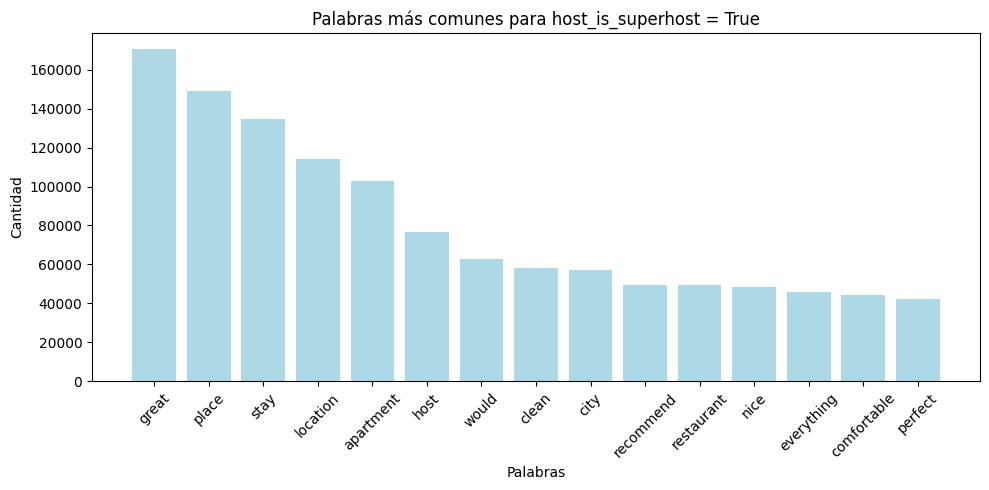

In [22]:
#Histogramas de frecuencia por clase

# Función para graficar histogramas de palabras más frecuentes por clase
def histograma(df, columna_clase, columna_texto='clean_text', top_palabras=15):
    
    # Tomamos cada valor distinto de la columna que vamos analizar
    clases = df[columna_clase].dropna().unique()
    
    for clase in clases:
        # Filtramos los textos que pertenecen a esa clase
        textos = df[df[columna_clase] == clase][columna_texto]
        
        # Unimos todos los textos en uno solo y lo separamos en palabras
        palabras = ' '.join(textos).split()
        
        # Contamos las palabras que mas han sido repetidas
        contador = Counter(palabras)
        mas_comunes = contador.most_common(top_palabras)
        
        if not mas_comunes:
            continue  
        
        # Separamos palabras y conteos
        palabras_top, conteos = zip(*mas_comunes)
        
        # Hacemos el gráfico de barras con las palabras
        plt.figure(figsize=(10, 5))
        plt.bar(palabras_top, conteos, color='lightblue')
        plt.title(f'Palabras más comunes para {columna_clase} = {clase}')
        plt.xlabel('Palabras')
        plt.ylabel('Cantidad')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('Histogramas de clases')
        plt.show()

# Usamos la función para las columnas room type y host_is_superhost
histograma(df_EN, 'room_type')
histograma(df_EN, 'host_is_superhost')

In [23]:
#Preprocesamiento de datos estructurados
#Para nuestro caso ya en la parte de arriba hemos realizado pre evaluacion de las columnas y eliminamos las no relevantes.
#Adicional ya hemos realizado el tratamiento de valores nulos (en la parte de arriba)

#Evaluamos el tipo de dato de cada columna
#print (df_EN.head(25))
#print (df_EN.dtypes)

#Antes de la codificacion volvemos a reducir el dataframe con  las columnas mas relevantes y las que dejaremos para el modelado
columnas_extras = ['listing_id', 'host_id', 'id_x', 'id_y', 'name','review_scores_rating', 'description', 'comments', 'neighborhood_overview', 'amenities', 'comentario_limpio']
df_final = df_EN.drop (columns = columnas_extras)
print (df_final)

        host_is_superhost                property_type        room_type  \
0                   False  Private room in rental unit     Private room   
1                   False  Private room in rental unit     Private room   
2                   False  Private room in rental unit     Private room   
3                   False  Private room in rental unit     Private room   
4                   False  Private room in rental unit     Private room   
...                   ...                          ...              ...   
405043              False           Entire rental unit  Entire home/apt   
405044              False           Entire rental unit  Entire home/apt   
405045              False           Entire rental unit  Entire home/apt   
405046              False           Entire rental unit  Entire home/apt   
405047              False           Entire rental unit  Entire home/apt   

        bathrooms_text   price  number_of_reviews  target  \
0                  1.0   851.0        

In [24]:
#Codificar variables categoticas como room_type, property_type y host_is_superhost (son las previamente escogidas)
#Aplicamos one-hot encoded para codificar las variables property y room
df_codificado = pd.get_dummies(df_final, columns=['property_type', 'room_type'], drop_first=True)

# Convertimos a host_is_superhost en true= 1, false= 0
df_codificado['host_is_superhost'] = df_codificado['host_is_superhost'].astype(int)

#Dataframe codificado
print(df_codificado.head(25))

    host_is_superhost  bathrooms_text  price  number_of_reviews  target  \
0                   0             1.0  851.0                 70       1   
1                   0             1.0  851.0                 70       1   
2                   0             1.0  851.0                 70       1   
3                   0             1.0  851.0                 70       1   
4                   0             1.0  851.0                 70       1   
5                   0             1.0  851.0                 70       1   
6                   0             1.0  851.0                 70       1   
7                   0             1.0  851.0                 70       1   
8                   0             1.0  851.0                 70       1   
9                   0             1.0  851.0                 70       1   
10                  0             1.0  851.0                 70       1   
11                  0             1.0  851.0                 70       1   
12                  0    

In [25]:
#Normalizar Valores Numericos.
# Seleccionamos las columnas numéricas de nuestro datafram df_final
c_numericas = ['bathrooms_text', 'price', 'number_of_reviews']

# Creamos el escalador hemos seleccionado Standard Scarler
scaler = StandardScaler()

# Aplicamos  la estandarización sobre las columnas numericas
df_codificado[c_numericas] = scaler.fit_transform(df_codificado[c_numericas])

#DataFrame estandarizado
print(df_codificado)


        host_is_superhost  bathrooms_text     price  number_of_reviews  \
0                       0       -0.593513 -0.448641          -0.757508   
1                       0       -0.593513 -0.448641          -0.757508   
2                       0       -0.593513 -0.448641          -0.757508   
3                       0       -0.593513 -0.448641          -0.757508   
4                       0       -0.593513 -0.448641          -0.757508   
...                   ...             ...       ...                ...   
405043                  0        0.596112 -0.081118          -0.698036   
405044                  0        0.596112 -0.081118          -0.698036   
405045                  0        0.596112 -0.081118          -0.698036   
405046                  0        0.596112 -0.081118          -0.698036   
405047                  0        0.596112 -0.081118          -0.698036   

        target                                         clean_text  \
0            1  elizabeth family outstandi

In [26]:
#Verificamos los valores nulos nuevamente
nulos = df_final.isnull().sum()
print(nulos)

host_is_superhost    0
property_type        0
room_type            0
bathrooms_text       0
price                0
number_of_reviews    0
target               0
clean_text           0
dtype: int64


In [27]:
#Integración Texto + Variables Estructuradas:

#Separamos las variables X y Y
X = df_final.drop(columns=['target']) 
y = df_final['target']   

#Entrenamiento de las variables
    
#Dividir en entrenamiento y prueba 80/20,
#Usamos Statify para asegurar que la división de los datos en conjuntos de entrenamiento y prueba mantenga la misma proporción de clases que se encuentra en el conjunto de datos original.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Definimos variables para las columnas para no colocarlas en la transformacion
texto = 'clean_text'
numericas = ['bathrooms_text', 'price', 'number_of_reviews']
categoricas = ['host_is_superhost', 'property_type', 'room_type']

#Definimos las tranformaciones

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=100)
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore') 

#ColumnTransformer
preprocesador = ColumnTransformer(
    transformers=[
        ('texto', tfidf, texto),
        ('num', scaler, numericas),
        ('cat', ohe, categoricas)
    ])

In [28]:
#Evaluacion del Target para ver como esta distribuida
conteo = df_final['target'].value_counts()
print (conteo)

target
1    398977
0      6071
Name: count, dtype: int64


In [29]:
#Modelos predictivos: Los escogidos fueron Regreson Logistica, RandomForest,  Gradient Boosting

#Regresion Logistica
#Entrenar con Pipeline

#Creamos el pipeline
#Usamos Smote para ayudar con el desbalance del target
lr_pipeline =  ImbPipeline([
   ('preprocesamiento', preprocesador),
   ('smote', SMOTE(random_state=42)),
   ('modelo', LogisticRegression(max_iter=1000, random_state=42))
])
#Prueba sin over sampling
#lr_pipeline = Pipeline([
    #('preprocesamiento', preprocesador),
    #('modelo', LogisticRegression(max_iter=1000, random_state=42))
#])

#Definimos los hiperparámetros del grid
lr_hiperparametros = {
    'modelo__C': [0.01, 0.1, 1, 10],
    'modelo__penalty': ['l2'],
    'modelo__solver': ['lbfgs']}

# Hacemos búsqueda con validación cruzada
#Se realizarán 3 divisiones para evaluar el rendimiento del modelo.
#Se usa roc_auc ya que mantenemos un desbalance en el target
lr_grid = GridSearchCV(lr_pipeline, lr_hiperparametros, cv=3, scoring='roc_auc', n_jobs=-1)

# Entrenamos el modelo con grid y datos balanceados
lr_grid.fit(X_train, y_train)

# Predecimos usando modelo 
y_pred_lr = lr_grid.predict(X_test)

print("Mejores Parámetros de Regresión Logistica:", lr_grid.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_lr))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr))

Mejores Parámetros de Regresión Logistica: {'modelo__C': 0.1, 'modelo__penalty': 'l2', 'modelo__solver': 'lbfgs'}

Accuracy: 0.7651894827799037

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.05      0.81      0.09      1214
           1       1.00      0.76      0.87     79796

    accuracy                           0.77     81010
   macro avg       0.52      0.79      0.48     81010
weighted avg       0.98      0.77      0.85     81010



In [30]:
#RandomForest

#Creamos el pipeline
rf_pipeline = ImbPipeline([
    ('preprocesamiento', preprocesador),
    ('smote', SMOTE(random_state=42)),
    ('modelo', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Definimos los hiperparámetros del grid
rf_hiperparametro = {
    'modelo__n_estimators': [10, 50],
    'modelo__max_depth': [5, 10],
    'modelo__min_samples_split': [2, 5]}

# Hacemos búsqueda con validación cruzada
rf_grid = GridSearchCV(rf_pipeline, rf_hiperparametro, cv=3, scoring='roc_auc', n_jobs=-1)

# Entrenamos el modelo con grid
rf_grid.fit(X_train, y_train)

# Predecimos usando modelo 
y_pred_rf = rf_grid.predict(X_test)

print("Mejores parámetros Random Forest:", rf_grid.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_rf))
print("\nReporte:")
print(classification_report(y_test, y_pred_rf))

Mejores parámetros Random Forest: {'modelo__max_depth': 10, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 50}

Accuracy: 0.8496235032712011

Reporte:
              precision    recall  f1-score   support

           0       0.07      0.79      0.14      1214
           1       1.00      0.85      0.92     79796

    accuracy                           0.85     81010
   macro avg       0.54      0.82      0.53     81010
weighted avg       0.98      0.85      0.91     81010



In [31]:
# Gradient Boosting

#Creamos el pipeline
gb_pipeline = ImbPipeline([
    ('preprocesamiento', preprocesador),
    ('smote', SMOTE(random_state=42)),
    ('modelo', GradientBoostingClassifier(random_state=42))
])

# Definimos los hiperparámetros del grid
gb_hiperparametro = {
    'modelo__n_estimators': [20, 50],           
    'modelo__learning_rate': [0.1],            
    'modelo__max_depth': [2, 3]}                

# Hacemos búsqueda con validación cruzada
gb_grid = GridSearchCV(gb_pipeline, gb_hiperparametro, cv=3, scoring='roc_auc', n_jobs=-1)

# Entrenamos el modelo con grid
gb_grid.fit(X_train, y_train)

# Predecimos usando modelo 
y_pred_gb = gb_grid.predict(X_test)

print("Mejores parámetros Gradient Boosting:", gb_grid.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_gb))
print("\nReporte:")
print(classification_report(y_test, y_pred_gb))

Mejores parámetros Gradient Boosting: {'modelo__learning_rate': 0.1, 'modelo__max_depth': 3, 'modelo__n_estimators': 50}

Accuracy: 0.8202320701148006

Reporte:
              precision    recall  f1-score   support

           0       0.07      0.89      0.13      1214
           1       1.00      0.82      0.90     79796

    accuracy                           0.82     81010
   macro avg       0.53      0.85      0.51     81010
weighted avg       0.98      0.82      0.89     81010




Evaluación del modelo de Regresión Logistica:

Accuracy: 0.7651894827799037
Precision: 0.9963249705997648
Recall: 0.7644368138753822
F1 Score: 0.8651113317259963

Matrix de confusión para Regresión Logística

[[  989   225]
 [18797 60999]]


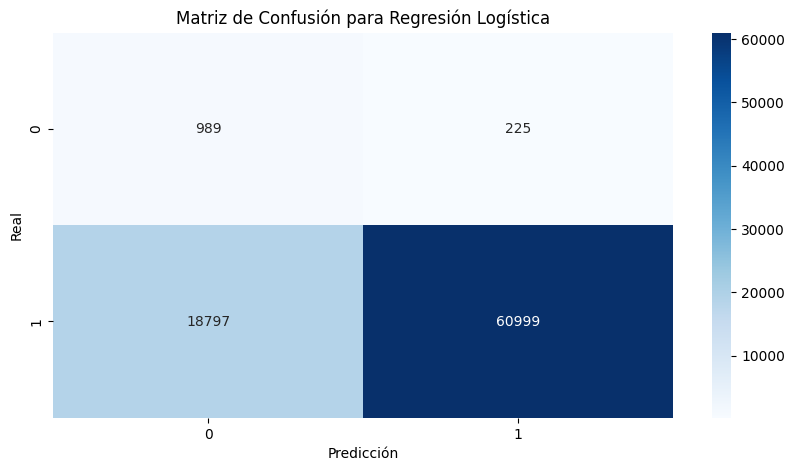

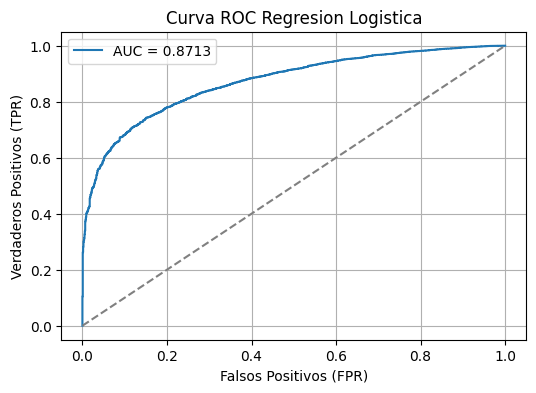

In [32]:
# Evaluación de los Modelos

#Regresion Logistica
print('\nEvaluación del modelo de Regresión Logistica:\n')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))
print('\nMatrix de confusión para Regresión Logística\n')
print(confusion_matrix(y_test, y_pred_lr))

#Matriz de Confunsion
plt.figure(figsize=(10, 5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión para Regresión Logística')
plt.savefig('matriz_confusion_lr.png')
plt.show()

#Curva ROC
y_prob_lr = lr_grid.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
auc = roc_auc_score(y_test, y_prob_lr)


plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdaderos Positivos (TPR)")
plt.title("Curva ROC Regresion Logistica")
plt.legend()
plt.grid(True)
plt.savefig('Curva ROC Regresion Logistica.png')
plt.show()


Evaluación del modelo de Random Forest:

Accuracy: 0.8496235032712011
Precision: 0.9962568257882685
Recall: 0.8505313549551355
F1 Score: 0.917644672796106

Matrix de confusión para Random Forest

[[  959   255]
 [11927 67869]]


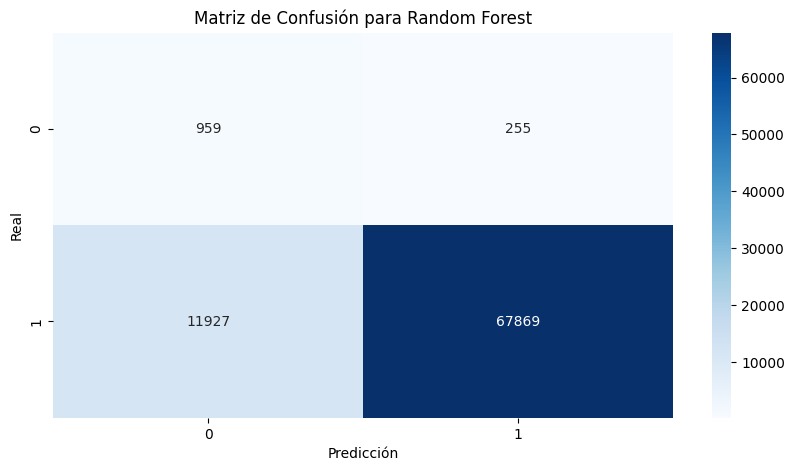

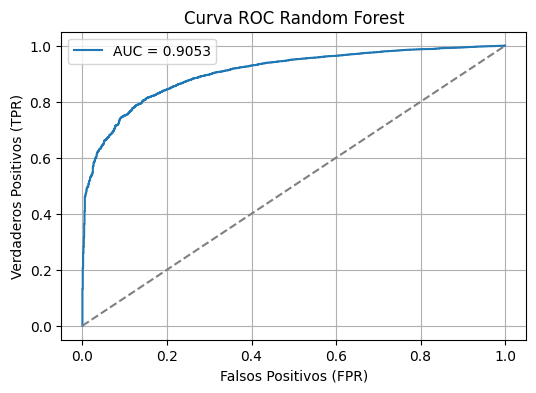

In [33]:
#Random Forest
print('\nEvaluación del modelo de Random Forest:\n')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('\nMatrix de confusión para Random Forest\n')
print(confusion_matrix(y_test, y_pred_rf))

#Matriz de Confunsion
plt.figure(figsize=(10, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión para Random Forest')
plt.savefig('matriz_confusion_rf.png')
plt.show()

#Curva ROC
y_prob_rf = rf_grid.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel('Falsos Positivos (FPR)')
plt.ylabel('Verdaderos Positivos (TPR)')
plt.title('Curva ROC Random Forest')
plt.savefig('Curva ROC Random Forest.png')
plt.legend()
plt.grid(True)
plt.show()


Evaluación del modelo de Gradient Boosting:

Accuracy: 0.8202320701148006
Precision: 0.9979238226089612
Recall: 0.8192014637325179
F1 Score: 0.8997735734785033

Matrix de confusión para Gradient Boosting

[[ 1078   136]
 [14427 65369]]


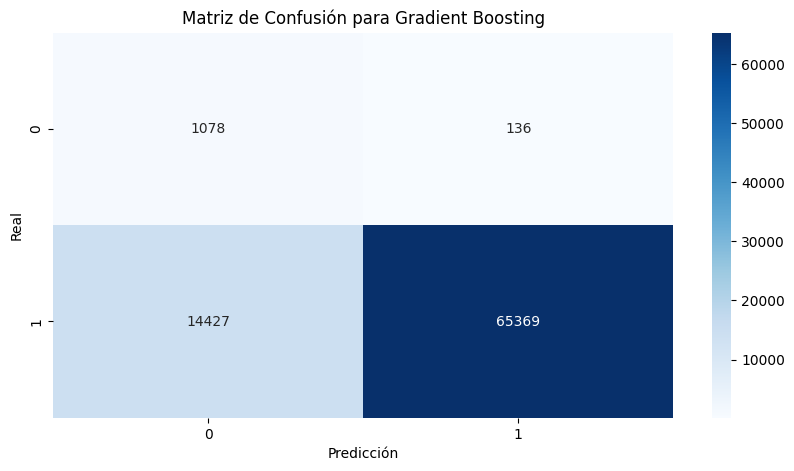

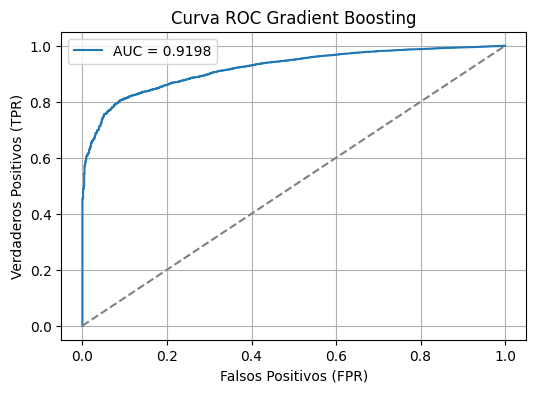

In [34]:
#Gradient Boosting
print('\nEvaluación del modelo de Gradient Boosting:\n')
print('Accuracy:', accuracy_score(y_test, y_pred_gb))
print('Precision:', precision_score(y_test, y_pred_gb))
print('Recall:', recall_score(y_test, y_pred_gb))
print('F1 Score:', f1_score(y_test, y_pred_gb))
print('\nMatrix de confusión para Gradient Boosting\n')
print(confusion_matrix(y_test, y_pred_gb))

#Matriz de Confunsion
plt.figure(figsize=(10, 5))
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión para Gradient Boosting')
plt.savefig('matriz_confusion_gb.png')
plt.show()

#Curva ROC
y_prob_gb = gb_grid.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gb)
auc = roc_auc_score(y_test,y_prob_gb)


plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdaderos Positivos (TPR)")
plt.title("Curva ROC Gradient Boosting")
plt.savefig('Curva ROC Gradient Boosting.png')
plt.legend()
plt.grid(True)
plt.show()

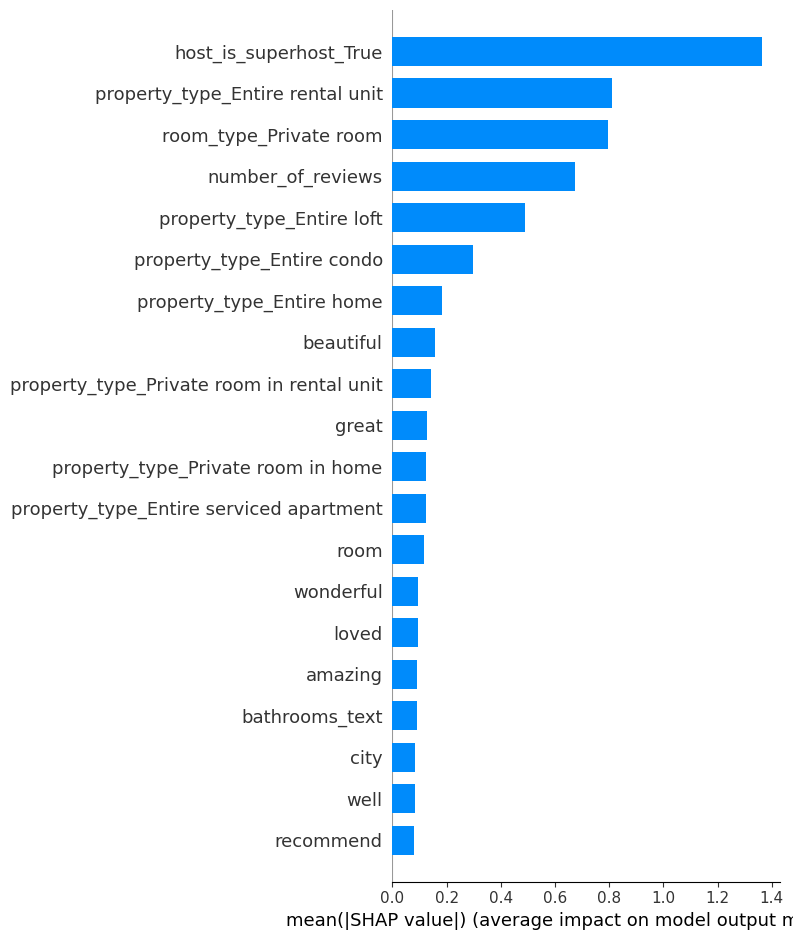

<Figure size 640x480 with 0 Axes>

Top 20 características más importantes(Regresión Logística):
host_is_superhost_True                       1.362292
property_type_Entire rental unit             0.808971
room_type_Private room                       0.794244
number_of_reviews                            0.674027
property_type_Entire loft                    0.489417
property_type_Entire condo                   0.297507
property_type_Entire home                    0.183289
beautiful                                    0.157560
property_type_Private room in rental unit    0.142832
great                                        0.128367
property_type_Private room in home           0.124669
property_type_Entire serviced apartment      0.122100
room                                         0.116580
wonderful                                    0.095416
loved                                        0.094406
amazing                                      0.091149
bathrooms_text                               0.089962
city                 

In [35]:
#SHAP para regresion Logistica

#Extraemos el pipeline entrenado
pipe_lr = lr_grid.best_estimator_
preprocesador_lr = pipe_lr.named_steps['preprocesamiento']
modelo_lr = pipe_lr.named_steps['modelo']

#Transformamos X_test 
X_test_array_lr = preprocesador_lr.transform(X_test)

numericas = ['bathrooms_text', 'price', 'number_of_reviews']
categoricas = ['host_is_superhost', 'property_type', 'room_type']
texto = 'clean_text'

tfidf_lr = preprocesador_lr.named_transformers_['texto']
ohe_lr = preprocesador_lr.named_transformers_['cat']

nombres_texto_lr = tfidf_lr.get_feature_names_out()
nombres_cat_lr = ohe_lr.get_feature_names_out(categoricas)
feature_names_lr = np.concatenate([nombres_texto_lr, numericas, nombres_cat_lr])

#Calculamos SHAP values
explainer_lr = shap.Explainer(modelo_lr, X_test_array_lr)
shap_values_lr = explainer_lr(X_test_array_lr)

#Revisamos dimensiones
#print("X_test_array shape:", X_test_array_lr.shape)
#print("shap_values.values shape:", shap_values_lr.values.shape)
#print("Número de feature_names:", len(feature_names_lr))

#Gráfico de barras (Top 20 features más importantes)
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_values_lr.values, X_test_array_lr, feature_names=feature_names_lr, plot_type="bar", max_display=20)
plt.tight_layout()
plt.show()

#Top 20 características más importantes
importancia_lr = np.abs(shap_values_lr.values).mean(axis=0)
top_features_lr = pd.Series(importancia_lr, index=feature_names_lr).sort_values(ascending=False)

print('Top 20 características más importantes(Regresión Logística):')
print(top_features_lr.head(20))

100%|===================| 161962/162020 [12:44<00:00]        

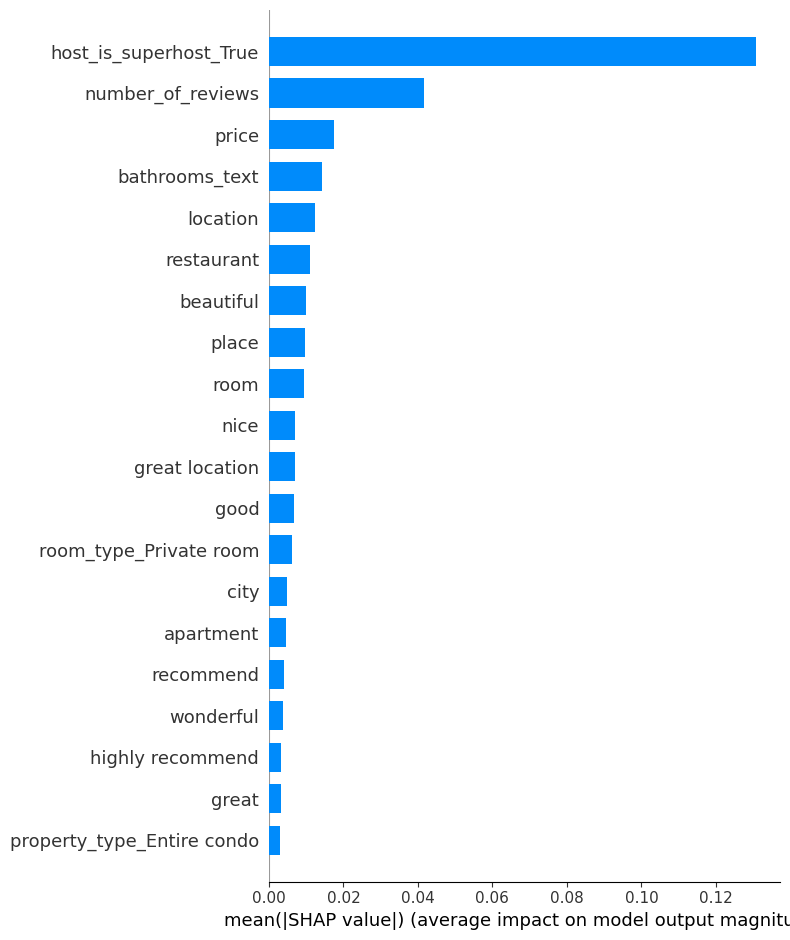

<Figure size 640x480 with 0 Axes>

Top 20 características más importantes (Random Forest):
host_is_superhost_True        0.130682
number_of_reviews             0.041701
price                         0.017343
bathrooms_text                0.014161
location                      0.012370
restaurant                    0.010932
beautiful                     0.010057
place                         0.009547
room                          0.009293
nice                          0.007019
great location                0.006947
good                          0.006736
room_type_Private room        0.006286
city                          0.004959
apartment                     0.004442
recommend                     0.003947
wonderful                     0.003652
highly recommend              0.003321
great                         0.003285
property_type_Entire condo    0.003068
dtype: float64


In [36]:
#SHAP para Random Forest

#Extraer pipeline, preprocesador y modelo
pipe_rf = rf_grid.best_estimator_
preprocesador_rf = pipe_rf.named_steps['preprocesamiento']
modelo_rf = pipe_rf.named_steps['modelo']

numericas = ['bathrooms_text', 'price', 'number_of_reviews']
categoricas = ['host_is_superhost', 'property_type', 'room_type']
texto = 'clean_text'

tfidf_rf = preprocesador_rf.named_transformers_['texto']
ohe_rf = preprocesador_rf.named_transformers_['cat']

nombres_texto_rf = tfidf_rf.get_feature_names_out()
nombres_cat_rf = ohe_rf.get_feature_names_out(categoricas)
feature_names_rf = np.concatenate([nombres_texto_rf, numericas, nombres_cat_rf])

#Tranformamos X_test
X_test_array_rf = preprocesador_rf.transform(X_test)

#Calculamos SHAP values
explainer_rf = shap.Explainer(modelo_rf, X_test_array_rf)
shap_values_rf = explainer_rf(X_test_array_rf, check_additivity=False)

# Extraemos valores para clase positiva (índice 1)
shap_vals_clase_1_rf = shap_values_rf.values[:, :, 1]

#Gráfico barras importancia
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_vals_clase_1_rf, X_test_array_rf, feature_names=feature_names_rf, plot_type="bar", max_display=20)
plt.tight_layout()
plt.show()


# Top 20 características más importantes Random Forest
importancia_rf = np.abs(shap_values_rf.values[:, :, 1]).mean(axis=0)
top_features_rf = pd.Series(importancia_rf, index=feature_names_rf).sort_values(ascending=False)

print('Top 20 características más importantes (Random Forest):')
print(top_features_rf.head(20))

 98%|===================| 79729/81010 [00:46<00:00]        

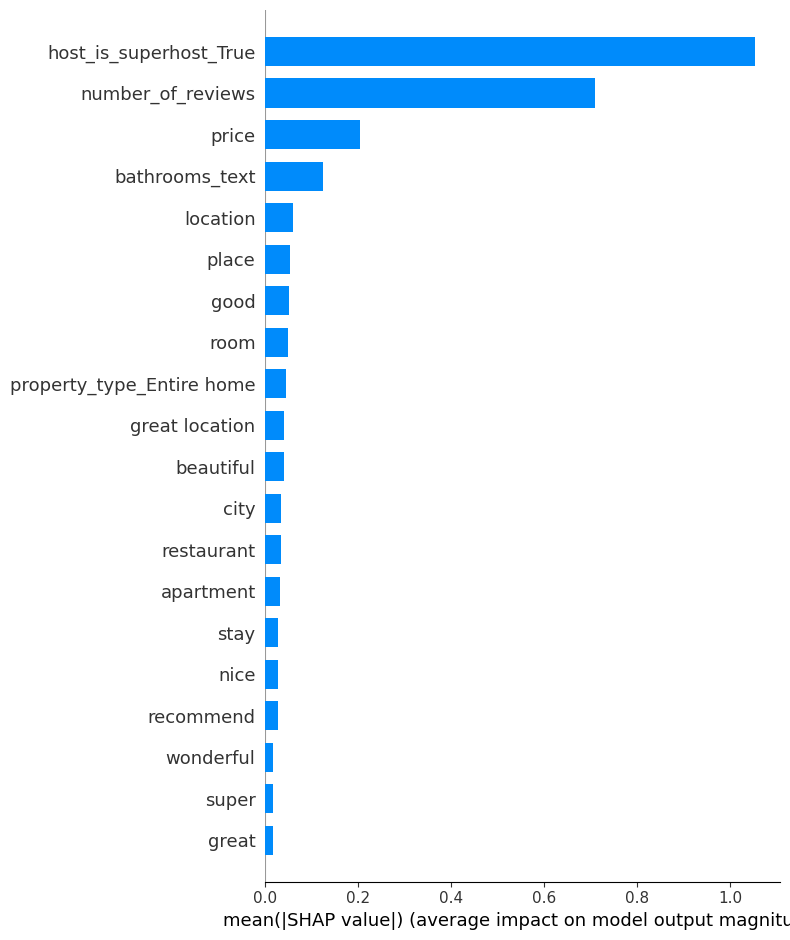

<Figure size 640x480 with 0 Axes>

Top 20 características más importantes (Gradient Boosting):
host_is_superhost_True       1.054064
number_of_reviews            0.708290
price                        0.202858
bathrooms_text               0.123821
location                     0.058572
place                        0.053187
good                         0.051227
room                         0.049695
property_type_Entire home    0.044214
great location               0.039636
beautiful                    0.039104
city                         0.033587
restaurant                   0.033389
apartment                    0.030539
stay                         0.027575
nice                         0.027068
recommend                    0.026938
wonderful                    0.017439
super                        0.016303
great                        0.016157
dtype: float64


In [37]:
#Shap para Gradient Boosting
#Extraemos pipeline, preprocesador y modelo
pipe_gb = gb_grid.best_estimator_
preprocesador_gb = pipe_gb.named_steps['preprocesamiento']
modelo_gb = pipe_gb.named_steps['modelo']

numericas = ['bathrooms_text', 'price', 'number_of_reviews']
categoricas = ['host_is_superhost', 'property_type', 'room_type']
texto = 'clean_text'

tfidf_gb = preprocesador_gb.named_transformers_['texto']
ohe_gb = preprocesador_gb.named_transformers_['cat']

nombres_texto_gb = tfidf_gb.get_feature_names_out()
nombres_cat_gb = ohe_gb.get_feature_names_out(categoricas)
feature_names_gb = np.concatenate([nombres_texto_gb, numericas, nombres_cat_gb])

#Transformamos X_test
X_test_array_gb = preprocesador_gb.transform(X_test)

#Calculamos SHAP values
explainer_gb = shap.Explainer(modelo_gb, X_test_array_gb)
shap_values_gb = explainer_gb(X_test_array_gb, check_additivity=False)

#Extraemos valores para clase positiva 
shap_vals_clase_1_gb = shap_values_gb.values

#Gráfico barras importancia
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_vals_clase_1_gb, X_test_array_gb, feature_names=feature_names_gb, plot_type="bar", max_display=20)
plt.tight_layout()
plt.show()

#Top 20 características más importantes Gradient Boosting
importancia_gb = np.abs(shap_values_gb.values).mean(axis=0)
top_features_gb = pd.Series(importancia_gb, index=feature_names_gb).sort_values(ascending=False)

print('Top 20 características más importantes (Gradient Boosting):')
print(top_features_gb.head(20))

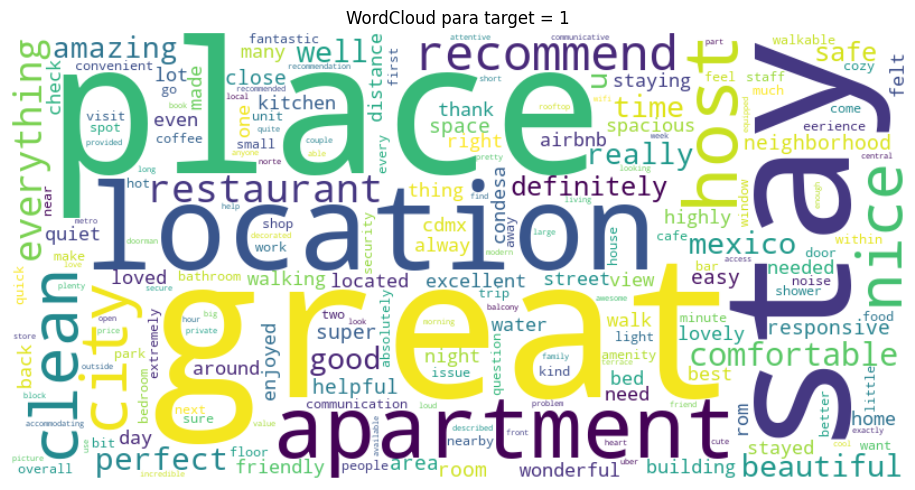

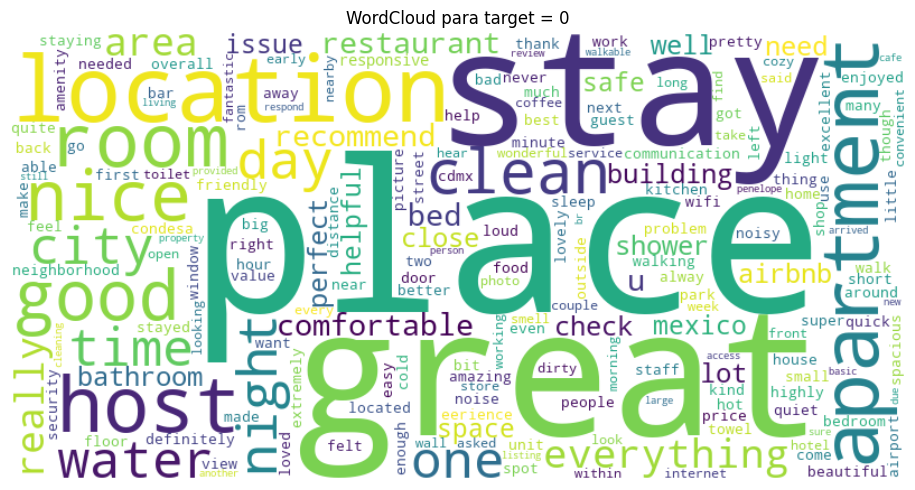

In [38]:
#Visualización de Resultados

#WordClouds por categoría de rating.
from wordcloud import WordCloud
 
# WordCloud por clase (target)
def wordcloud_por_clase(df, clase_col='target', texto_col='clean_text'):
    clases = df[clase_col].dropna().unique()
    for clase in clases:
        texto = ' '.join(df[df[clase_col] == clase][texto_col])
        wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(texto)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud para target = {clase}')
        plt.tight_layout()
        plt.savefig(f'wordcloud_target_{clase}.png')
        plt.show()
 
# Ejecutar
wordcloud_por_clase(df_final)

Analisis de Sentimientos Opcional

"Como análisis adicional, se aplicó análisis de sentimiento a los comentarios usando TextBlob. Se observó que la mayoría de los comentarios tienen sentimiento positivo, lo cual es coherente con la distribución de la variable objetivo. No se incorporó esta variable al modelo debido a que la información ya se encuentra reflejada parcialmente en el texto procesado mediante TF-IDF."


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


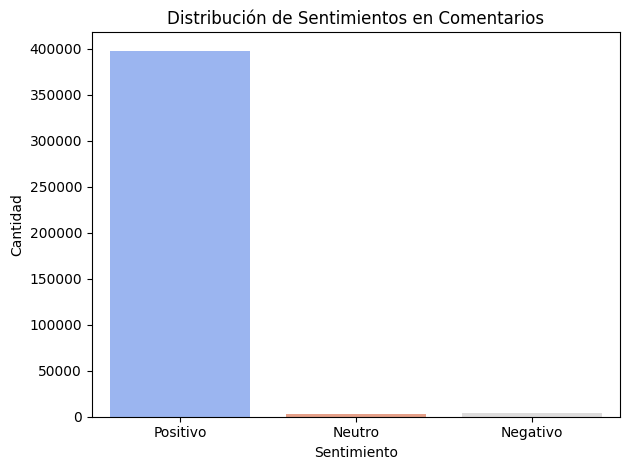

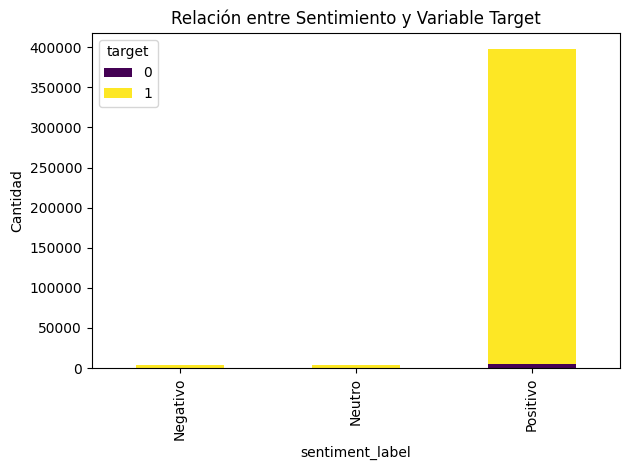

In [39]:
#Analisis de Sentimiento
 
#Inicializamos VADER
nltk.download('vader_lexicon') 
sia = SentimentIntensityAnalyzer()

#Calculamos puntajes de sentimiento
df_final['sentiment_scores'] = df_final['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

#Clasificamos sentimiento como positivo, negativo o neutro
def sentimiento(score):
    if score >= 0.05:
        return 'Positivo'
    elif score <= -0.05:
        return 'Negativo'
    else:
        return 'Neutro'

df_final['sentiment_label'] = df_final['sentiment_scores'].apply(sentimiento)

#Gráfico de distribución del sentimiento:
sns.countplot(x='sentiment_label', hue='sentiment_label', data=df_final, 
              order=['Positivo', 'Neutro', 'Negativo'], palette='coolwarm', legend=False)
plt.title('Distribución de Sentimientos en Comentarios')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

#Relación entre sentimiento y target
sent_vs_target = df_final.groupby(['sentiment_label', 'target']).size().unstack().fillna(0)
sent_vs_target.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Relación entre Sentimiento y Variable Target')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()